#### Mapping CryoSat-2 fits
Creates a mosaic of CryoSat-2 tiles applying weights to each tile

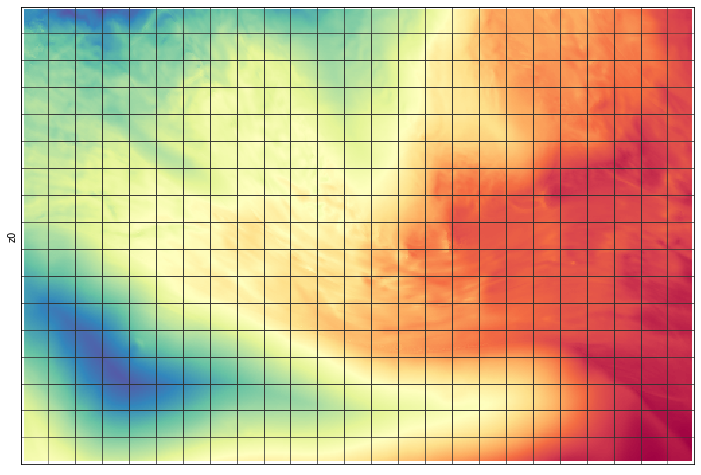

In [10]:
import glob
import re
import numpy as np
import pointCollection as pc
import matplotlib.pyplot as plt

# directory with CryoSat-2 files
thedir = '/Volumes/ice2/ben/CS2_fit/AA/centers'

# create figure axis
fig, hax = plt.subplots(num=1, figsize=(11,16))

# weight parameters
# pad width
W0 = 1e3
# feathering width
WF = 2e3

# find list of valid files
ctr_dict={}
file_list = []
for file in glob.glob(thedir+'/*.h5'):
    xc,yc=[int(item)*1.e3 for item in re.compile('E(.*)_N(.*).h5').search(file).groups()]
    file_list.append(file)
    
# get bounds, grid spacing and dimensions of output mosaic
mosaic=pc.grid.mosaic()
for file in file_list:
    # read CryoSat-2 grid from HDF5
    temp=pc.grid.mosaic().from_h5( file, group='z0/', field_mapping={'z':'z0'})
    ctr_dict[(np.mean(temp.x), np.mean(temp.y))]=file
    # update grid spacing of output mosaic
    mosaic.update_spacing(temp)
    # update the extents of the output mosaic
    mosaic.update_bounds(temp)
    # update dimensions of output mosaic
    mosaic.update_dimensions(temp)

# create output mosaic
mosaic.data = np.zeros(mosaic.dimensions)
mosaic.mask = np.ones(mosaic.dimensions,dtype=np.bool)
mosaic.weight = np.zeros((mosaic.dimensions[0],mosaic.dimensions[1]))
for file in file_list:
    # read CryoSat-2 grid from HDF5
    temp=pc.grid.mosaic().from_h5( file, group='z0/', field_mapping={'z':'z0'})
    temp=temp.weights(pad=W0, feather=WF, apply=True)
    # get the image coordinates of the input file
    iy,ix = mosaic.image_coordinates(temp)
    for band in range(mosaic.dimensions[2]):
        mosaic.data[iy,ix,band] += temp.z[:,:,band]
        mosaic.mask[iy,ix,band] = False
    # add weights to total weight matrix
    mosaic.weight[iy,ix] += temp.weight[:,:]
    # plot tile extents
    xmin,xmax,ymin,ymax = temp.extent
    xbox = [xmin,xmax,xmax,xmin,xmin]
    ybox = [ymin,ymin,ymax,ymax,ymin]
    hax.plot(xbox,ybox,c='0.2',lw=0.5,zorder=1)

# find valid weights
iy,ix = np.nonzero(mosaic.weight == 0)
mosaic.mask[iy,ix,:] = True
# normalize weights
iy,ix = np.nonzero(mosaic.weight > 0)
for band in range(mosaic.dimensions[2]):
    mosaic.data[iy,ix,band] /= mosaic.weight[iy,ix]
# replace invalid points with fill_value
mosaic.data[mosaic.mask] = mosaic.fill_value

# show mosaic image of elevation
hax.imshow(mosaic.data[:,:,0], extent=mosaic.extent, cmap='Spectral', origin='lower')
# set x and y labels
hax.set_ylabel('z0')
hax.set_xticks([])
hax.set_yticks([])

hax.set_xlim(mosaic.extent[0:2])
hax.set_ylim(mosaic.extent[2:4])

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.05, top=0.95, hspace=0.05, wspace=0.1)
plt.show()